In [ ]:
import torch
from torch import Tensor
import torch.nn as nn
import torch.optim as optim
import numpy as np


In [ ]:
class RBFNet(nn.Module):
    def __init__(self, input_dim, sigma=1.0):
        super(RBFNet, self).__init__()
        self.input_dim = input_dim
        self.centers = nn.Parameter(Tensor([]), requires_grad=True)
        self.sigma = sigma  # Fixed sigma for simplicity in this iterative OLS context

        # The linear layer will be initialized dynamically
        self.linear_layer = None

    def set_weights_and_centers(self, weights: Tensor, centers: Tensor, bias: float):
        """
        Set the weights and centers of the RBF network.
        :param weights: Tensor of shape (num_rbfs, 1)
        :param centers: Tensor of shape (num_rbfs, input_dim)
        """

        self.centers.data = centers
        self.linear_layer = nn.Linear(self.centers.shape[0], 1, bias=True)
        self.linear_layer.weight.data = (
            weights.T
        )  # Transpose to match the expected shape
        self.linear_layer.bias.data = torch.tensor([bias], dtype=torch.float32)

    def radial_basis_function(self, x, center, sigma):
        # x: (batch_size, input_dim)
        # center: (input_dim,)
        # sigma: scalar
        diff = x - center
        dist_sq = torch.sum(diff**2, dim=1)
        sigma_sq = sigma**2 + 1e-8  # Add epsilon for stability
        return torch.exp(-dist_sq / (2 * sigma_sq))

    def forward(self, x):
        if self.centers.shape[0] == 0:
            # If no RBFs are selected yet, return zeros (or raise error based on desired behavior)
            return torch.zeros(x.size(0), 1, device=x.device)

        batch_size = x.size(0)
        num_rbfs = self.centers.shape[0]
        rbf_activations = torch.empty(batch_size, num_rbfs, device=x.device)

        diffs = x.unsqueeze(1) - self.centers.unsqueeze(
            0
        )  # Shape: (batch_size, num_rbfs, input_dim)
        dist_sq = torch.sum(diffs**2, dim=2)  # Shape: (batch_size, num_rbfs)
        # Add epsilon for numerical stability
        sigma_sq = self.sigma**2 + 1e-8  # Shape: (batch_size, num_rbfs)
        rbf_activations = torch.exp(
            -dist_sq / (2 * sigma_sq)
        )  # Shape: (batch_size, num_rbfs)

        # Pass RBF activations through the linear output layer
        output = self.linear_layer(rbf_activations)  # Shape: (batch_size, 1)
        return output

    @property
    def num_rbfs(self):
        return self.centers.shape[0]


In [ ]:
# --- Generate Synthetic Time Series Data ---
def synthetic_time_series(num_samples=200):
    """Generate a 1D time series"""
    t = torch.linspace(0, 4 * torch.pi, num_samples)
    # Create a more complex time series
    y = (
        torch.sin(t)
        + 0.5 * torch.cos(3 * t)
        + 0.3 * torch.sin(5 * t)
        + torch.randn(num_samples) * 0.1
    )
    return y


In [ ]:
def create_delay_embedding(time_series, embedding_dim=5, delay=1):
    """
    Create delay embedded vectors from a time series.

    Parameters:
    - time_series: 1D tensor of shape (T,) where T is the length of time series
    - embedding_dim: Number of delay coordinates (dimension of embedded vectors)
    - delay: Time delay between coordinates

    Returns:
    - X: Input vectors of shape (N, embedding_dim) where N = T - (embedding_dim-1)*delay
    - y: Target values of shape (N,) - next values to predict
    """
    T = len(time_series)
    max_delay = (embedding_dim - 1) * delay

    if T <= max_delay + 1:  # +1 because we need one more sample for the offset target
        raise ValueError(
            f"Time series too short. Need at least {max_delay + 2} samples."
        )

    N = T - max_delay
    X = torch.zeros(N, embedding_dim)

    # Create delay embedded vectors
    for i in range(N):
        for j in range(embedding_dim):
            X[i, j] = time_series[i + j * delay]

    # Target is the NEXT value after the embedding window (t+1 prediction)
    # This prevents data leakage where the target would be the same as the last input
    y = time_series[max_delay + 1 :].clone()

    # Adjust N to account for the offset target
    N = N - 1
    X = X[:N]  # Remove the last input vector since it has no corresponding target

    return X, y


In [ ]:
def synthetic_data_for_range_embedded(
    t_start, t_end, num_samples=200, embedding_dim=5, delay=1
):
    """Generate delay embedded data for a specific time range"""
    t = torch.linspace(t_start, t_end, num_samples)
    # Create a more complex time series

    time_series = (
        torch.sin(t)
        + 0.5 * torch.cos(3 * t)
        + 0.3 * torch.sin(5 * t)
        + torch.randn(num_samples) * 0.1
    )

    X, y = create_delay_embedding(time_series, embedding_dim, delay)
    return X, y.unsqueeze(1)  # Add dimension to y for consistency


In [ ]:
def train_rbf_iterative_ols_custom(
    model: RBFNet,
    X: Tensor,
    y: Tensor,
    max_rbfs: int = 50,
    tolerance: float = 0.01,
    candidate_centers: Tensor | None = None,
    device: torch.device | str | None = None,
    epsilon: float = 1e-8,
) -> RBFNet:
    r"""
    This function implements an iterative OLS training for RBF networks.
    The naming convention follows the original RBF OLS paper, where the algorithm
    is described as selecting RBF centers iteratively based on the reduction of residuals.

    You can find the original paper here:
    https://core.ac.uk/download/pdf/1497907.pdf

    Parameters:
    - model: RBFNet instance to train
    - X: Input training data of shape (N, D) where N is the number of samples and D is the input dimension
    - y: Target values of shape (N, 1) where N is the number of samples
    - max_rbfs: Maximum number of RBF centers to select
    - tolerance: denoted with \rho, this parameter determines the stopping criterion for the algorithm.
    - candidate_centers: Optional tensor of shape (M, D) where M is the number of candidate centers.
      If None, all training data points will be used as candidates.
    - device: Optional string specifying the device to use ('cpu' or 'cuda') or a torch.device.
      If None, will use cuda if available, otherwise CPU.
    - epsilon: Small value to avoid division by zero in calculations

    Returns:
    - model: The trained RBFNet model with selected RBF centers and weights.

    Raises:
    - ValueError: If the device is not a string or None or torch.device.

    """

    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    elif isinstance(device, str):
        device = torch.device(device)
    elif isinstance(device, torch.device):
        # Already a torch.device, no conversion needed
        pass
    else:
        raise ValueError(
            "Device must be a string or torch.device or None, got: {}".format(
                type(device)
            )
        )

    X = X.to(device)
    d = y.to(device).squeeze()

    assert X.dim() == 2, "X_train must be a 2D tensor (N, D)"
    assert d.dim() == 1, "y_train must be a 1D tensor (N,)"

    # N is the number of samples
    N = X.size(0)
    assert N > 0, "X_train must have at least one sample"

    # D is the input dimension
    D = X.size(1)
    assert D > 0, "X_train must have at least one feature (D > 0)"

    assert model.input_dim == X.size(
        1
    ), f"Model input dimension {model.input_dim} does not match X_train dimension {X.size(1)}"
    assert X.size(0) == d.size(
        0
    ), f"Number of samples in X_train ({X.size(0)}) must match y_train ({d.size(0)})"

    model.to(device)

    if candidate_centers is None:
        candidate_centers = X.clone().detach()

        candidate_indices = list(
            range(candidate_centers.size(0))
        )  # Pool of unselected indices
    else:
        assert isinstance(
            candidate_centers, Tensor
        ), "candidate_centers must be a torch.Tensor"
        assert (
            candidate_centers.dim() == 2
        ), "candidate_centers must be a 2D tensor (M, D)"
        assert (
            candidate_centers.size(1) == model.input_dim
        ), f"candidate_centers input dimension {candidate_centers.size(1)} does not match model input dimension {model.input_dim}"

    num_candidates = candidate_centers.size(0)
    assert num_candidates > 0, "candidate_centers must have at least one center"

    M = max_rbfs
    assert M > 0, "max_rbfs must be greater than 0"

    assert tolerance > 0, "tolerance must be greater than 0"

    candidate_centers = candidate_centers.to(device)

    # P will contains the RBF activations for all candidate centers
    P: Tensor = torch.zeros(N, num_candidates, device=device)

    for i in range(P.size(1)):
        P[:, i] = model.radial_basis_function(X, candidate_centers[i], model.sigma)

    candidate_indices: list[int] = list(range(candidate_centers.size(0)))
    selected_indices: list[int] = []

    # A is an upper triangular matrix that will be built iteratively
    # - the main diagonal will contain only 1s
    # - the upper triangular part will be filled with the weights of the RBF centers (alphas)
    A: Tensor = torch.eye(M, device=device)

    # W represents the orthogonalized activations of the RBF centers
    # if P contains orthogonal columns, then W_i = P_i, otherwise
    # W will be updated iteratively and orthogonalized
    W: Tensor = torch.empty((N, M), device=device)

    # centralize d
    d_mean = float(torch.mean(d).item())  # Center the target values
    d = d - d_mean

    sum_err: float = 0.0  # Initialize the sum of errors

    # M_s is the number of selected RBF centers
    M_s = M

    # precomputations for more efficient calculations
    dTd_add_eps = d.T @ d + epsilon

    for k in range(1, M + 1):

        if len(candidate_indices) == 0:
            print("No more candidate centers available.")
            break

        # first step
        if k == 1:

            max_err_1 = -float("inf")
            w_1 = None
            i_1 = -1

            for i in candidate_indices:
                # w_1ˇi = p_i[]
                w_1ˇi = P[:, i].view(-1, 1)

                w_1ˇiˇT_times_w_1ˇi = w_1ˇi.T @ w_1ˇi

                # g_1ˇi = w_1ˇi^T * residuals / (w_1ˇi^T * w_1ˇi + epsilon)
                g_1ˇi = (w_1ˇi.T @ d) / (w_1ˇiˇT_times_w_1ˇi + epsilon)
                # err_1ˇi = g_1ˇi ^ 2 * w_1ˇi^T * w_1ˇi / d^T * d
                err_1ˇi = g_1ˇi**2 * w_1ˇiˇT_times_w_1ˇi / dTd_add_eps

                if err_1ˇi > max_err_1:
                    max_err_1 = err_1ˇi.item()
                    w_1 = w_1ˇi
                    i_1 = i

            if i_1 == -1:
                print(f"WARNING: could not find center after {k} iterations")
                continue

            W[:, 0] = w_1.squeeze()
            candidate_indices.remove(i_1)
            selected_indices.append(i_1)

            sum_err += max_err_1

        else:  # k >= 2 step

            max_err_k = -float("inf")
            w_kˇi_k: Tensor | None = None
            i_k: int = -1
            alphasˇi_k = torch.empty(k - 1, device=device)

            # buffer, where the alpha variables are put
            alphas = torch.empty(k - 1, device=device)

            for i in candidate_indices:

                # orthogonalization step
                # --> this is the main idea of the OLS algorithm, and why the former weights
                #     don't have to be adjusted after each new center, we add in.

                for j in range(k - 1):
                    # alphas_j,kˇi = w_j^T * p_i / (w_j^T * w_j + epsilon)
                    w_j = W[:, j].view(-1, 1)  # w_j is the j-th column of W
                    p_i = P[:, i].view(-1, 1)  # p_i is the i-th column of P
                    alphas[j] = (w_j.T @ p_i) / (w_j.T @ w_j + epsilon)

                # w_kˇi = p_i - sum_{j=1}^{k-1}{a_jkˇi * w_j}
                # where a_jkˇi is the j-th alpha for the i-th candidate
                w_kˇi = P[:, i].view(-1, 1) - torch.sum(
                    alphas * W[:, : k - 1], dim=1, keepdim=True
                )

                w_kˇiˇT_times_w_kˇi = w_kˇi.T @ w_kˇi

                # g_kˇi = w_kˇi^T * residuals / (w_kˇi^T * w_kˇi + epsilon)
                g_kˇi = (w_kˇi.T @ d) / (w_kˇiˇT_times_w_kˇi + epsilon)
                # err_kˇi = g_kˇi ^ 2 * w_kˇi^T * w_kˇi / d^T * d
                err_kˇi = g_kˇi**2 * w_kˇiˇT_times_w_kˇi / dTd_add_eps

                if err_kˇi > max_err_k:
                    max_err_k = err_kˇi.item()
                    w_kˇi_k = w_kˇi
                    i_k = i
                    alphasˇi_k = alphas.clone()

            if i_k == -1:
                print(f"WARNING: could not find center after {k} iterations")
                continue

            # w_k = w_kˇi_k = p_{i_k} - sum_{j=1}^{k-1}{a_jkˇi_k * w_j}
            W[:, k - 1] = w_kˇi_k.squeeze()
            candidate_indices.remove(i_k)
            selected_indices.append(i_k)

            # Update the upper triangular matrix A
            A[: k - 1, k - 1] = alphasˇi_k.view(-1)

            sum_err += max_err_k

        # stopping criterion
        if (1.0 - sum_err) < tolerance:
            print(
                f"Stopping after step {k}: sum_err (1 - {sum_err:.3f} = {(1.0 - sum_err):.3f}) < residual_threshold ({tolerance})."
            )
            M_s = k
            break
    else:
        print(f"Reach the maximum number of centers ({max_rbfs})")

    # throw away the unused columns of W and A
    W = W[:, :M_s]
    A = A[:M_s, :M_s]

    # d = P @ theta_hat + eps
    # d = W @ g + eps
    # P = W @ A
    # A @ theta_hat = g_hat
    # g_hat =(W^T * W)^{-1} * W^T * d
    # --> g_hat = Moore-Penrose pseudo-inverse of W times d

    H = W.T @ W
    # add the epsilon to the diagonal for numerical stability
    H_inv = torch.linalg.pinv(H + epsilon * torch.eye(H.size(0), device=device))

    g_hat = (H_inv @ W.T) @ d

    # A @ theta_hat = g_hat
    theta_hat = torch.linalg.solve_triangular(
        A, g_hat.view(-1, 1), upper=True, unitriangular=True, left=True
    )

    model.set_weights_and_centers(
        weights=theta_hat,
        centers=candidate_centers[selected_indices, :],
        # bias=0.0,
        bias=d_mean,
    )

    return model


In [124]:
# --- Delay Embedding Parameters ---
embedding_dim = 5  # Number of delay coordinates
delay = 1  # Time delay between coordinates
# Generate training data on a limited time range for extrapolation testing
X, y = synthetic_data_for_range_embedded(
    0, 2 * torch.pi, num_samples=150, embedding_dim=embedding_dim, delay=delay
)

# Generate test data for extrapolation (future time steps), continuous with training
X_test, y_test = synthetic_data_for_range_embedded(
    2 * torch.pi,
    3 * torch.pi,
    num_samples=80 + embedding_dim * delay,
    embedding_dim=embedding_dim,
    delay=delay,
)
# Remove the first (embedding_dim * delay) samples from X_test and y_test to ensure continuity
X_test = X_test[embedding_dim * delay :]
y_test = y_test[embedding_dim * delay :]

# Also create full range data for visualization
X_full, y_full = synthetic_data_for_range_embedded(
    0, 3 * torch.pi, num_samples=250, embedding_dim=embedding_dim, delay=delay
)

# --- Hyperparameters for iterative OLS ---
input_dim = X.size(1)  # Now this will be the embedding dimension
fixed_sigma = 2.0  # Sigma is fixed for all RBFs in this iterative approach
max_rbfs_to_build = 40  # Maximum number of RBFs to add
target_residual_mse = 0.1  # Stop when MSE drops below this


# --- Initialize RBF Network (starts empty) ---
rbf_net = RBFNet(input_dim=input_dim, sigma=fixed_sigma)

# --- Train with Iterative OLS (Error Reduction Ratio based) ---
rbf_net = train_rbf_iterative_ols_custom(
    rbf_net,
    X,
    y,
    max_rbfs=max_rbfs_to_build,
    tolerance=target_residual_mse,
    device="cuda" if torch.cuda.is_available() else "cpu",
)


Stopping after step 2: sum_err (1 - 0.908 = 0.092) < residual_threshold (0.1).


In [125]:
# --- Evaluate the Model ---
rbf_net.eval()
with torch.no_grad():
    # Evaluate on training data
    train_predictions = rbf_net(X)
    train_mse = torch.mean((train_predictions - y) ** 2)
    print(f"\nTraining MSE: {train_mse.item():.4f}")

    # Evaluate on extrapolation test data
    test_predictions = rbf_net(X_test)
    test_mse = torch.mean((test_predictions - y_test) ** 2)
    print(f"Extrapolation Test MSE: {test_mse.item():.4f}")

    # Get predictions for full range for visualization
    full_predictions = rbf_net(X_full)

    print(f"Total RBFs in final model: {rbf_net.num_rbfs}")



Training MSE: 0.0610
Extrapolation Test MSE: 0.0474
Total RBFs in final model: 2


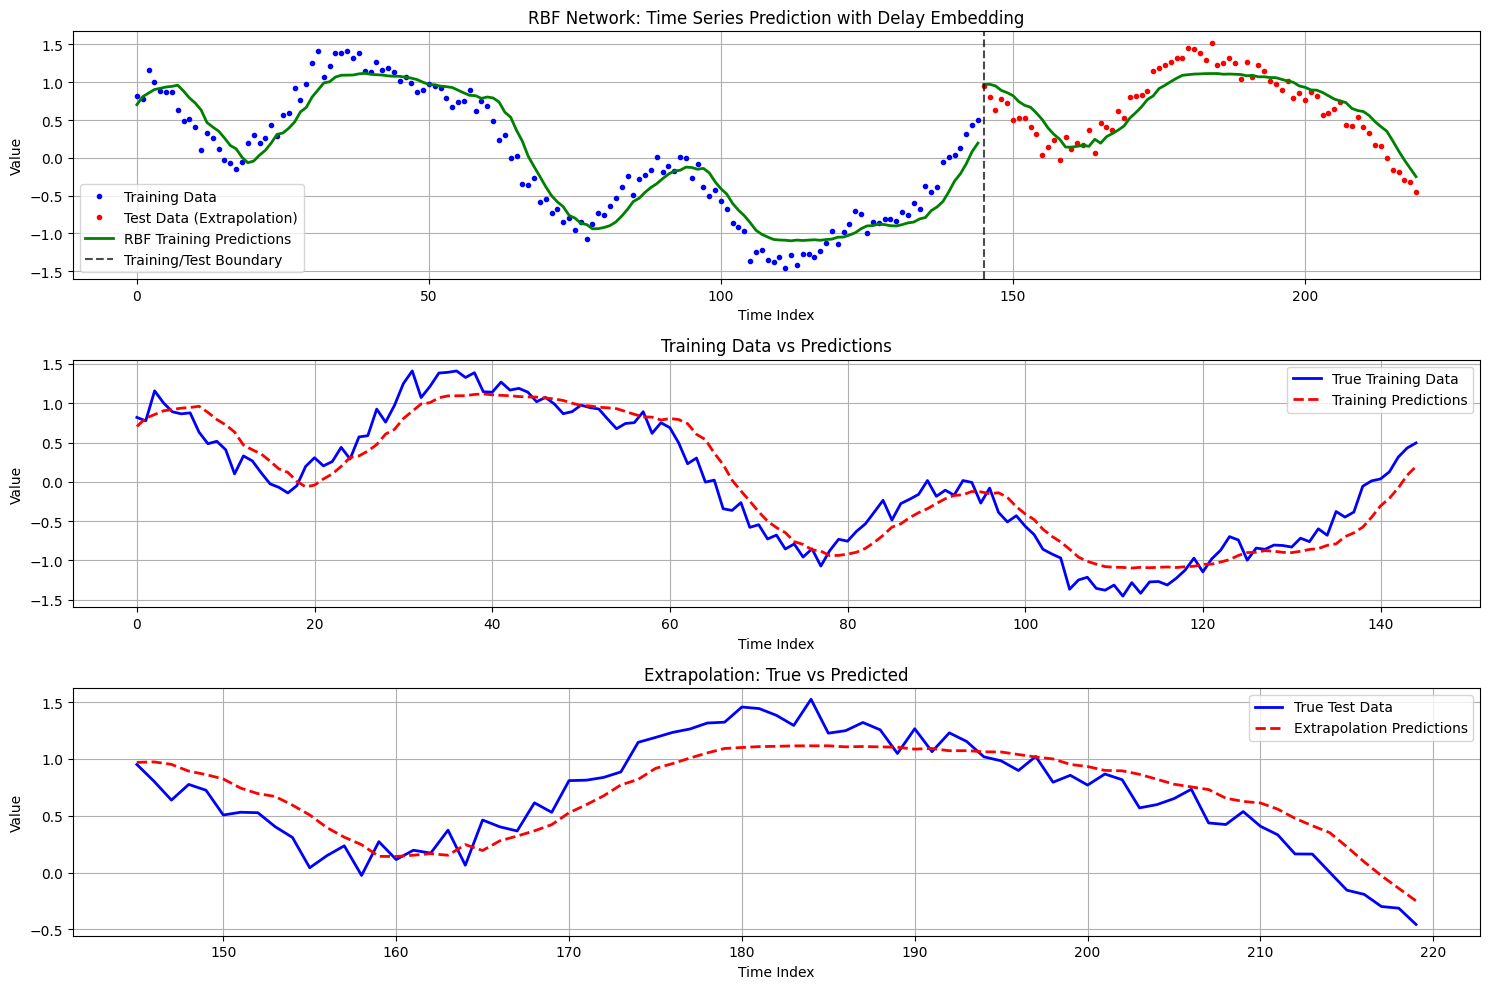

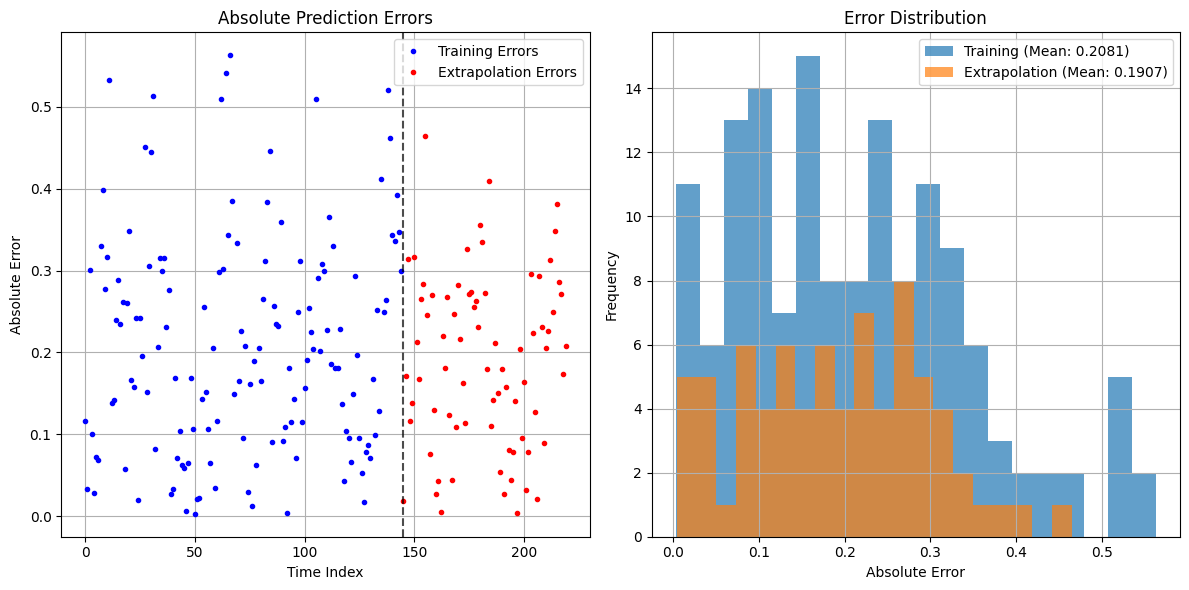

In [126]:
# --- Plotting Results ---
import matplotlib.pyplot as plt

# Create time indices for plotting
train_time_idx = torch.arange(len(y))
test_time_idx = torch.arange(len(y), len(y) + len(y_test))
full_time_idx = torch.arange(len(y_full))

plt.figure(figsize=(15, 10))

# Plot time series predictions
plt.subplot(3, 1, 1)
plt.plot(
    train_time_idx.cpu().numpy(),
    y.cpu().numpy(),
    "bo",
    label="Training Data",
    markersize=3,
)
plt.plot(
    test_time_idx.cpu().numpy(),
    y_test.cpu().numpy(),
    "ro",
    label="Test Data (Extrapolation)",
    markersize=3,
)
# Plot training predictions
plt.plot(
    train_time_idx.cpu().numpy(),
    train_predictions.cpu().numpy(),
    "g-",
    label="RBF Training Predictions",
    linewidth=2,
)
# Plot test predictions
plt.plot(
    test_time_idx.cpu().numpy(),
    test_predictions.cpu().numpy(),
    "g-",
    linewidth=2,
)
plt.axvline(
    x=len(y), color="k", linestyle="--", alpha=0.7, label="Training/Test Boundary"
)
plt.title("RBF Network: Time Series Prediction with Delay Embedding")
plt.xlabel("Time Index")
plt.ylabel("Value")
plt.legend()
plt.grid(True)

# Plot training vs prediction comparison
plt.subplot(3, 1, 2)
plt.plot(
    train_time_idx.cpu().numpy(),
    y.cpu().numpy(),
    "b-",
    label="True Training Data",
    linewidth=2,
)
plt.plot(
    train_time_idx.cpu().numpy(),
    train_predictions.cpu().numpy(),
    "r--",
    label="Training Predictions",
    linewidth=2,
)
plt.title("Training Data vs Predictions")
plt.xlabel("Time Index")
plt.ylabel("Value")
plt.legend()
plt.grid(True)

# Plot extrapolation comparison
plt.subplot(3, 1, 3)
plt.plot(
    test_time_idx.cpu().numpy(),
    y_test.cpu().numpy(),
    "b-",
    label="True Test Data",
    linewidth=2,
)
plt.plot(
    test_time_idx.cpu().numpy(),
    test_predictions.cpu().numpy(),
    "r--",
    label="Extrapolation Predictions",
    linewidth=2,
)
plt.title("Extrapolation: True vs Predicted")
plt.xlabel("Time Index")
plt.ylabel("Value")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# --- Error Analysis ---
plt.figure(figsize=(12, 6))

with torch.no_grad():
    train_errors = torch.abs(train_predictions - y).cpu().numpy()
    test_errors = torch.abs(test_predictions - y_test).cpu().numpy()

plt.subplot(1, 2, 1)
plt.plot(
    train_time_idx.cpu().numpy(),
    train_errors,
    "bo",
    label="Training Errors",
    markersize=3,
)
plt.plot(
    test_time_idx.cpu().numpy(),
    test_errors,
    "ro",
    label="Extrapolation Errors",
    markersize=3,
)
plt.axvline(x=len(y), color="k", linestyle="--", alpha=0.7)
plt.title("Absolute Prediction Errors")
plt.xlabel("Time Index")
plt.ylabel("Absolute Error")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.hist(
    train_errors,
    bins=20,
    alpha=0.7,
    label=f"Training (Mean: {np.mean(train_errors):.4f})",
)
plt.hist(
    test_errors,
    bins=20,
    alpha=0.7,
    label=f"Extrapolation (Mean: {np.mean(test_errors):.4f})",
)
plt.title("Error Distribution")
plt.xlabel("Absolute Error")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [121]:
# --- Inspecting Learned Parameters ---
print("\nDelay Embedding Analysis:")
print(f"Embedding Dimension: {embedding_dim}")
print(f"Time Delay: {delay}")
print(f"Input vectors represent: [y(t), y(t-{delay}), y(t-{2*delay}), ...]")

print("\nLearned RBF Centers:")
for i, center in enumerate(rbf_net.centers):
    center_vals = center.data.cpu().numpy()
    print(f"  Center {i+1}: [{', '.join([f'{val:.3f}' for val in center_vals])}]")

print(f"\nFixed RBF Sigma: {rbf_net.sigma}")
if rbf_net.linear_layer and rbf_net.num_rbfs > 0:
    print("\nLearned Output Layer Weights:")
    weights = rbf_net.linear_layer.weight.data.cpu().numpy()
    print(f"  Weights: [{', '.join([f'{w:.3f}' for w in weights[0]])}]")
    print(f"\nLearned Output Layer Bias:")
    if rbf_net.linear_layer.bias is not None:
        bias = rbf_net.linear_layer.bias.data.cpu().numpy()
        print(f"  Bias: {bias[0]:.3f}")
else:
    print("\nNo linear layer initialized (no RBFs selected).")



Delay Embedding Analysis:
Embedding Dimension: 5
Time Delay: 1
Input vectors represent: [y(t), y(t-1), y(t-2), ...]

Learned RBF Centers:
  Center 1: [0.960, 1.150, 1.239, 1.275, 1.353]
  Center 2: [-1.044, -0.985, -1.254, -1.382, -1.473]

Fixed RBF Sigma: 1.0

Learned Output Layer Weights:
  Weights: [1.333, -1.450]

Learned Output Layer Bias:
  Bias: -0.012


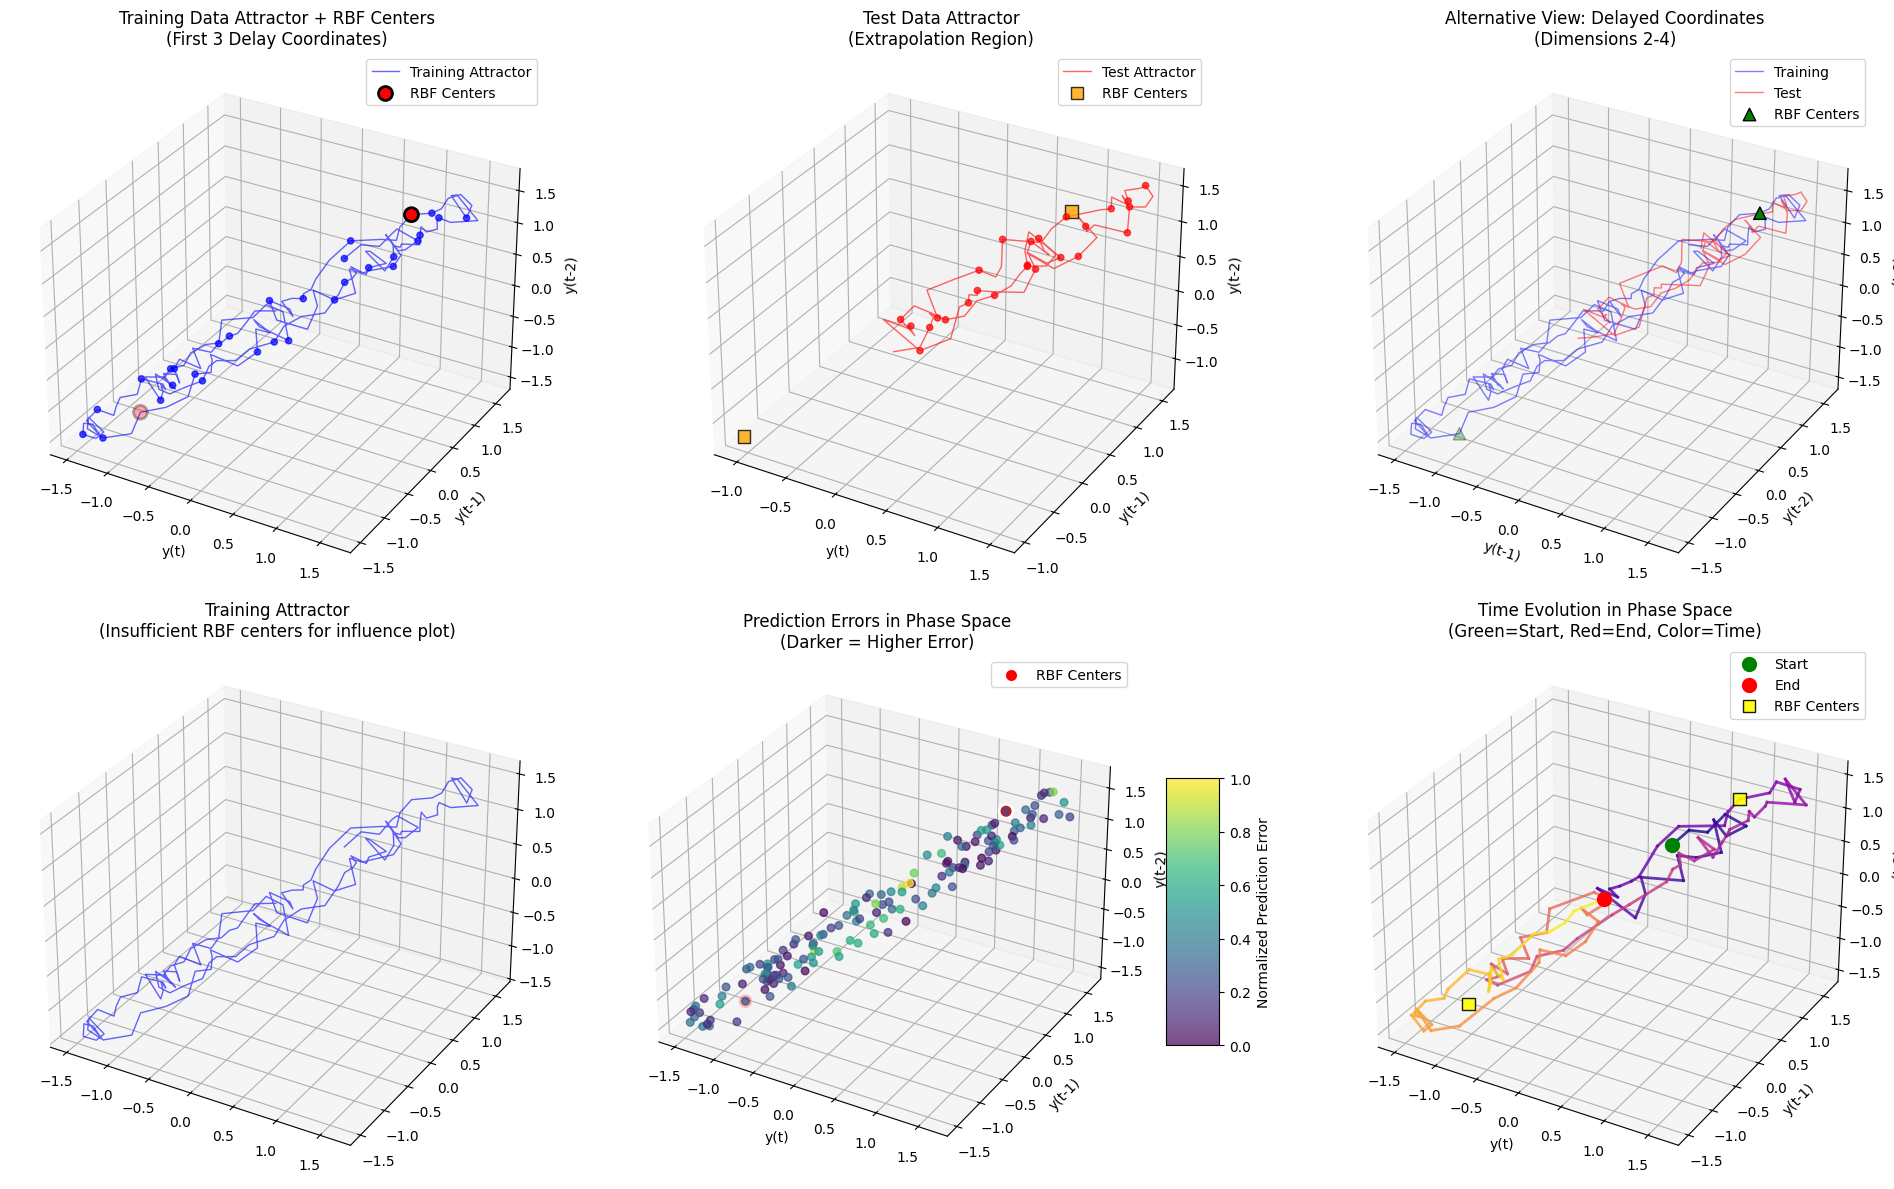


=== 3D Phase Space Analysis ===
Embedding dimension: 5
Number of RBF centers: 2
Training points in phase space: 145
Test points in phase space: 75

RBF Centers in 3D coordinates [y(t), y(t-1), y(t-2)]:
  Center 1: [0.960, 1.150, 1.239]
  Center 2: [-1.044, -0.985, -1.254]

Phase space centroid (training): [0.004, 0.001, -0.003]
Phase space spread (std): [0.840, 0.839, 0.838]


In [122]:
# --- 3D Phase-Space Visualization ---
from mpl_toolkits.mplot3d import Axes3D

# For 3D visualization, we need at least 3 dimensions
if embedding_dim >= 3:
    fig = plt.figure(figsize=(20, 12))

    # Plot 1: Training data attractor with RBF centers
    ax1 = fig.add_subplot(2, 3, 1, projection="3d")

    # Plot training data trajectory (attractor)
    train_x = X[:, 0].cpu().numpy()
    train_y = X[:, 1].cpu().numpy()
    train_z = X[:, 2].cpu().numpy()

    ax1.plot(
        train_x,
        train_y,
        train_z,
        "b-",
        alpha=0.6,
        linewidth=1,
        label="Training Attractor",
    )
    ax1.scatter(train_x[::5], train_y[::5], train_z[::5], c="blue", s=20, alpha=0.7)

    # Plot RBF centers
    if rbf_net.num_rbfs > 0:
        centers_x = [center[0].item() for center in rbf_net.centers]
        centers_y = [center[1].item() for center in rbf_net.centers]
        centers_z = [center[2].item() for center in rbf_net.centers]

        ax1.scatter(
            centers_x,
            centers_y,
            centers_z,
            c="red",
            s=100,
            marker="o",
            edgecolors="black",
            linewidth=2,
            label="RBF Centers",
        )

    ax1.set_xlabel("y(t)")
    ax1.set_ylabel("y(t-1)")
    ax1.set_zlabel("y(t-2)")
    ax1.set_title("Training Data Attractor + RBF Centers\n(First 3 Delay Coordinates)")
    ax1.legend()
    ax1.grid(True)

    # Plot 2: Test data attractor
    ax2 = fig.add_subplot(2, 3, 2, projection="3d")

    test_x = X_test[:, 0].cpu().numpy()
    test_y = X_test[:, 1].cpu().numpy()
    test_z = X_test[:, 2].cpu().numpy()

    ax2.plot(
        test_x, test_y, test_z, "r-", alpha=0.6, linewidth=1, label="Test Attractor"
    )
    ax2.scatter(test_x[::3], test_y[::3], test_z[::3], c="red", s=20, alpha=0.7)

    # Plot RBF centers for reference
    if rbf_net.num_rbfs > 0:
        ax2.scatter(
            centers_x,
            centers_y,
            centers_z,
            c="orange",
            s=80,
            marker="s",
            edgecolors="black",
            linewidth=1,
            label="RBF Centers",
            alpha=0.8,
        )

    ax2.set_xlabel("y(t)")
    ax2.set_ylabel("y(t-1)")
    ax2.set_zlabel("y(t-2)")
    ax2.set_title("Test Data Attractor\n(Extrapolation Region)")
    ax2.legend()
    ax2.grid(True)

    # Plot 3: Combined view with different dimensions (if available)
    if embedding_dim >= 4:
        ax3 = fig.add_subplot(2, 3, 3, projection="3d")

        # Use different delay coordinates for variety
        train_x2 = X[:, 1].cpu().numpy()  # y(t-1)
        train_y2 = X[:, 2].cpu().numpy()  # y(t-2)
        train_z2 = X[:, 3].cpu().numpy()  # y(t-3)

        test_x2 = X_test[:, 1].cpu().numpy()
        test_y2 = X_test[:, 2].cpu().numpy()
        test_z2 = X_test[:, 3].cpu().numpy()

        ax3.plot(
            train_x2, train_y2, train_z2, "b-", alpha=0.5, linewidth=1, label="Training"
        )
        ax3.plot(test_x2, test_y2, test_z2, "r-", alpha=0.5, linewidth=1, label="Test")

        # RBF centers in this coordinate system
        if rbf_net.num_rbfs > 0:
            centers_x2 = [center[1].item() for center in rbf_net.centers]
            centers_y2 = [center[2].item() for center in rbf_net.centers]
            centers_z2 = [center[3].item() for center in rbf_net.centers]

            ax3.scatter(
                centers_x2,
                centers_y2,
                centers_z2,
                c="green",
                s=80,
                marker="^",
                edgecolors="black",
                linewidth=1,
                label="RBF Centers",
            )

        ax3.set_xlabel("y(t-1)")
        ax3.set_ylabel("y(t-2)")
        ax3.set_zlabel("y(t-3)")
        ax3.set_title("Alternative View: Delayed Coordinates\n(Dimensions 2-4)")
        ax3.legend()
        ax3.grid(True)
    else:
        # If only 3 dimensions, show full data
        ax3 = fig.add_subplot(2, 3, 3, projection="3d")

        full_x = X_full[:, 0].cpu().numpy()
        full_y = X_full[:, 1].cpu().numpy()
        full_z = X_full[:, 2].cpu().numpy()

        # Color-code by time
        colors = plt.cm.viridis(np.linspace(0, 1, len(full_x)))
        ax3.scatter(full_x, full_y, full_z, c=colors, s=10, alpha=0.6)

        if rbf_net.num_rbfs > 0:
            ax3.scatter(
                centers_x,
                centers_y,
                centers_z,
                c="red",
                s=100,
                marker="o",
                edgecolors="black",
                linewidth=2,
                label="RBF Centers",
            )

        ax3.set_xlabel("y(t)")
        ax3.set_ylabel("y(t-1)")
        ax3.set_zlabel("y(t-2)")
        ax3.set_title("Full Time Series Attractor\n(Color = Time Progression)")
        ax3.legend()
        ax3.grid(True)

    # Plot 4: RBF activation visualization (if we have enough centers)
    ax4 = fig.add_subplot(2, 3, 4, projection="3d")

    if rbf_net.num_rbfs >= 3:
        # Show the first 3 RBF centers and their influence
        center1 = rbf_net.centers[0].detach().cpu().numpy()
        center2 = rbf_net.centers[1].detach().cpu().numpy()
        center3 = rbf_net.centers[2].detach().cpu().numpy()

        # Plot centers
        ax4.scatter(
            center1[0],
            center1[1],
            center1[2],
            c="red",
            s=200,
            marker="o",
            edgecolors="black",
            linewidth=2,
            label="Center 1",
        )
        ax4.scatter(
            center2[0],
            center2[1],
            center2[2],
            c="green",
            s=200,
            marker="s",
            edgecolors="black",
            linewidth=2,
            label="Center 2",
        )
        ax4.scatter(
            center3[0],
            center3[1],
            center3[2],
            c="blue",
            s=200,
            marker="^",
            edgecolors="black",
            linewidth=2,
            label="Center 3",
        )

        # Plot some training points and color them by distance to nearest center
        sample_indices = np.random.choice(len(X), min(200, len(X)), replace=False)
        sample_points = X[sample_indices].cpu().numpy()

        # Calculate distance to nearest center for coloring
        distances_to_centers = []
        for point in sample_points:
            dist1 = np.linalg.norm(point[:3] - center1[:3])
            dist2 = np.linalg.norm(point[:3] - center2[:3])
            dist3 = np.linalg.norm(point[:3] - center3[:3])
            min_dist = min(dist1, dist2, dist3)
            if dist1 == min_dist:
                distances_to_centers.append(0)  # Closest to center 1
            elif dist2 == min_dist:
                distances_to_centers.append(1)  # Closest to center 2
            else:
                distances_to_centers.append(2)  # Closest to center 3

        colors_map = ["red", "green", "blue"]
        for i, point in enumerate(sample_points):
            ax4.scatter(
                point[0],
                point[1],
                point[2],
                c=colors_map[distances_to_centers[i]],
                s=20,
                alpha=0.6,
            )

        ax4.set_xlabel("y(t)")
        ax4.set_ylabel("y(t-1)")
        ax4.set_zlabel("y(t-2)")
        ax4.set_title("RBF Center Influence\n(Points colored by nearest center)")
        ax4.legend()
        ax4.grid(True)
    else:
        # Fallback: just show the attractor
        ax4.plot(train_x, train_y, train_z, "b-", alpha=0.6, linewidth=1)
        ax4.set_title(
            "Training Attractor\n(Insufficient RBF centers for influence plot)"
        )
        ax4.grid(True)

    # Plot 5: Prediction errors in 3D space
    ax5 = fig.add_subplot(2, 3, 5, projection="3d")

    with torch.no_grad():
        train_errors_3d = torch.abs(train_predictions - y).cpu().numpy().flatten()

    # Normalize errors for color mapping
    norm_errors = (train_errors_3d - train_errors_3d.min()) / (
        train_errors_3d.max() - train_errors_3d.min() + 1e-8
    )

    scatter = ax5.scatter(
        train_x, train_y, train_z, c=norm_errors, cmap="viridis", s=30, alpha=0.7
    )

    if rbf_net.num_rbfs > 0:
        ax5.scatter(
            centers_x,
            centers_y,
            centers_z,
            c="red",
            s=100,
            marker="o",
            edgecolors="white",
            linewidth=2,
            label="RBF Centers",
        )

    ax5.set_xlabel("y(t)")
    ax5.set_ylabel("y(t-1)")
    ax5.set_zlabel("y(t-2)")
    ax5.set_title("Prediction Errors in Phase Space\n(Darker = Higher Error)")
    ax5.legend()
    ax5.grid(True)

    # Add colorbar
    cbar = plt.colorbar(scatter, ax=ax5, shrink=0.5, aspect=5)
    cbar.set_label("Normalized Prediction Error")

    # Plot 6: Phase space trajectory with time evolution
    ax6 = fig.add_subplot(2, 3, 6, projection="3d")

    # Create a trajectory that shows time evolution
    n_points = min(100, len(X))
    time_subset = np.linspace(0, len(X) - 1, n_points, dtype=int)

    for i in range(len(time_subset) - 1):
        idx = time_subset[i]
        next_idx = time_subset[i + 1]

        color_intensity = i / len(time_subset)

        ax6.plot(
            [X[idx, 0], X[next_idx, 0]],
            [X[idx, 1], X[next_idx, 1]],
            [X[idx, 2], X[next_idx, 2]],
            color=plt.cm.plasma(color_intensity),
            linewidth=2,
            alpha=0.8,
        )

    # Mark start and end points
    ax6.scatter(
        X[0, 0],
        X[0, 1],
        X[0, 2],
        c="green",
        s=100,
        marker="o",
        label="Start",
    )
    ax6.scatter(
        X[-1, 0],
        X[-1, 1],
        X[-1, 2],
        c="red",
        s=100,
        marker="o",
        label="End",
    )

    if rbf_net.num_rbfs > 0:
        ax6.scatter(
            centers_x,
            centers_y,
            centers_z,
            c="yellow",
            s=80,
            marker="s",
            edgecolors="black",
            linewidth=1,
            label="RBF Centers",
            alpha=0.9,
        )

    ax6.set_xlabel("y(t)")
    ax6.set_ylabel("y(t-1)")
    ax6.set_zlabel("y(t-2)")
    ax6.set_title("Time Evolution in Phase Space\n(Green=Start, Red=End, Color=Time)")
    ax6.legend()
    ax6.grid(True)

    plt.tight_layout()
    plt.show()

    # Additional information
    print(f"\n=== 3D Phase Space Analysis ===")
    print(f"Embedding dimension: {embedding_dim}")
    print(f"Number of RBF centers: {rbf_net.num_rbfs}")
    print(f"Training points in phase space: {len(X)}")
    print(f"Test points in phase space: {len(X_test)}")

    if rbf_net.num_rbfs > 0:
        print(f"\nRBF Centers in 3D coordinates [y(t), y(t-1), y(t-2)]:")
        for i, center in enumerate(rbf_net.centers):
            center_3d = center[:3].detach().cpu().numpy()
            print(
                f"  Center {i+1}: [{center_3d[0]:.3f}, {center_3d[1]:.3f}, {center_3d[2]:.3f}]"
            )

    # Calculate some phase space statistics
    train_centroid = torch.mean(X[:, :3], dim=0)
    print(
        f"\nPhase space centroid (training): [{train_centroid[0]:.3f}, {train_centroid[1]:.3f}, {train_centroid[2]:.3f}]"
    )

    # Calculate the "size" of the attractor
    train_std = torch.std(X[:, :3], dim=0)
    print(
        f"Phase space spread (std): [{train_std[0]:.3f}, {train_std[1]:.3f}, {train_std[2]:.3f}]"
    )

else:
    print(
        f"Cannot create 3D phase space plots: embedding dimension is {embedding_dim} (need >= 3)"
    )
    print(
        "Increase embedding_dim to at least 3 to visualize the phase space attractor."
    )


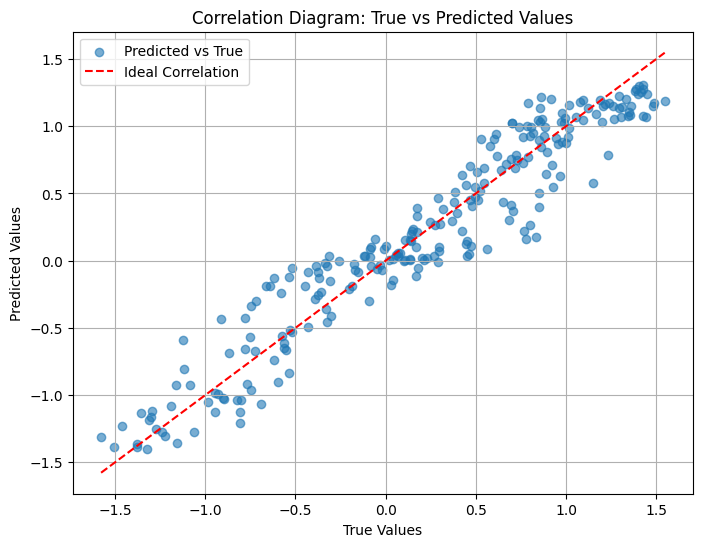

In [123]:
y_true = y_full.cpu().numpy().flatten()
y_pred = full_predictions.cpu().numpy().flatten()

plt.figure(figsize=(8, 6))
plt.scatter(y_true, y_pred, alpha=0.6, label="Predicted vs True")
plt.plot(
    [y_true.min(), y_true.max()],
    [y_true.min(), y_true.max()],
    "r--",
    label="Ideal Correlation",
)
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Correlation Diagram: True vs Predicted Values")
plt.legend()
plt.grid(True)
plt.show()
